# Pyiron workflows: quickstart

You can start converting python functions to `pyiron_workflow` nodes by wrapping them with decorators accessible from our single-point-of-entry, the `Workflow` class:

In [1]:
from pyiron_workflow import Workflow

## From function to node

Let's start with a super simple function that only returns a single thing

In [2]:
@Workflow.wrap.as_function_node
def AddOne(x):
    y = x + 1
    return y

node = AddOne()

This node object can be run just like the function it wraps

In [3]:
node(42)

43

But is also a class instance with input and output channels (note that here the output value takes its name based on what came after the `return` statement)

In [4]:
node.inputs.x = 0
node.run()
node.outputs.y.value

1

So other than being delayed, these nodes behave a _lot_ like the regular python functions that wrap them. E.g. we can nest them together just like a regular function:

In [5]:
calculation = AddOne(AddOne(AddOne(2)))
calculation()

5

But they are actually nodes, and what we saw above is just syntactic sugar for building a _graph_ connecting the inputs and outputs of the nodes:

In [6]:
n1 = AddOne()
n2 = AddOne()
n3 = AddOne()

n2.inputs.x = n1.outputs.y
n3.inputs.x = n2.outputs.y

n1.inputs.x = 0
n3()

3

In the special case that a node has only _one_ output channel (i.e. only one return value in the decorated function), this object will fall back on trying to perform operations on that output channel! Combining this with the syntactic sugar for using the function signature to set input values, we can equivalently write the example above as:

In [7]:
n1 = AddOne(x=0)
n2 = AddOne(x=n1)
n3 = AddOne(x=n2)
n3()

3

The names of input to nodes is pulled directly from the signature of the wrapped function. By default, we also scrape the names of the output labels this way. Sometimes you want to return something that looks "ugly" -- like `x + 1` in the example above. You can create a new local variable that looks "pretty" (`y = x + 1` above) and return that, or you can pass an output label to the decorator. Nodes also pull hints and defaults from the function they wrap. We can re-write our example above to leverage all of this:

In [8]:
@Workflow.wrap.as_function_node("y")
def AddOne(x: int) -> int:
    return x + 1

AddOne.preview_io()

{'inputs': {'x': (int, NOT_DATA)}, 'outputs': {'y': int}}

## Putting it together in a workflow

We can work with nodes all by themselves, but since the whole point is to connect them together to make a computation graph, we can get extra tools by intentionally making these children of a `Workflow` node.

The `Workflow` class not only gives us access to the decorators for defining new nodes, but also lets us access a core set of existing nodes. Let's put together a workflow that uses both an existing node from the creator, and another function node that has multiple return values. This function node will also exploit our ability to name outputs (in the decorator argument) and give type hints (in the function signature, as usual). 

In addition to using output channels (or nodes, if they have only a single output) to make connections to input channels, we can perform many (but not all) other python operations on them to dynamically create new nodes! Below see how we do math and indexing right on the output channels:

In [9]:
wf = Workflow("my_workflow")

@Workflow.wrap.as_function_node("range", "length")
def Range(n: int) -> tuple[list[int], int]:
    """
    Two outputs is silly overkill, but just to demonstrate how Function nodes work
    """
    r = range(n)
    return list(r), len(r)


wf.range = Range()
wf.last_square = wf.range.outputs.range[-1]**2

We also can visualize the workflow to see its constituents and connections:

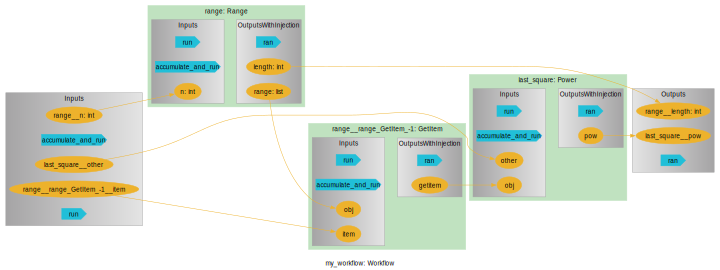

In [10]:
wf.draw(size=(10,10))

We can see that the workflow automatically exposes unconnected IO of its children and gives them a name based on the child node's name and that node's IO name. Further, the math and indexing we do automatically injects new nodes after the output. Note that even though we perform a slice on `wf.arange.outputs.arange` twice, only a single node is created and it simply gets reused -- the graph is aware of all the dynamically injected nodes and reuses them like this for computational efficiency.

Let's run our workflow and look at the result:

In [11]:
wf(range__n=5)

{'range__length': 5, 'last_square__pow': 16}

Unless it's turned off, `pyiron_workflow` will make sure that all new nodes and connections obey type hints (where provided). For instance, if we try to pass a non-int to our `square_range` node, we'll get an error:

In [12]:
try:
    wf.range.inputs.n = 5.5
except TypeError as e:
    message = e.args[0]
    print(message)

The channel n cannot take the value `5.5` because it is not compliant with the type hint <class 'int'>


## Composing complex workflows from macros

There's just one last step: once we have a workflow we're happy with, we can package it as a "macro"! This lets us make more and more complex workflows by composing sub-graphs.

We don't yet have an automated tool for converting workflows into macros, but we can create them by decorating a function that takes a macro instance and macro input, builds its graph, and returns the parts of it we want as macro output. We can do most of this by just copy-and-pasting our workflow above into a decorated function! 

Just like a function node, the IO of a macro is defined by the signature and return values of the function we're decorating. Just remember to include a `self`-like argument for the macro instance itself as the first argument, and (usually) to only return single-output nodes or output channels in the `return` statement:

In [13]:
@Workflow.wrap.as_function_node("next_line")
def Print(message: str, line_number: int = 0) -> int:
    print(line_number, message)
    return line_number + 1


@Workflow.wrap.as_macro_node("n_lines")
def EmailWithLineNumbers(
    self, 
    recipient: str, 
    body: str, 
    sender: str,
    honourific: str = "Dear ",
    salutation: str = "Sincerely,",
):
    
    # self.greeting = Workflow.create.standard.Add(honourific, " ") + recipient
    self.greet = Print(honourific + recipient + ",")
    self.communicate = Print(body, line_number=self.greet)
    self.conclude = Print(salutation, line_number=self.communicate)
    self.from_ = Print(sender, line_number=self.conclude)
    return self.from_

In [14]:
wf2 = Workflow("spam_template")

wf2.name = Workflow.create.standard.UserInput()
wf2.name.inputs.user_input.type_hint = str

wf2.lined_email = EmailWithLineNumbers(
    recipient=wf2.name,
    body="You may have won some free beer! Please send your credit card number.",
    sender="Elsinore Brewery",
    salutation="Hurry, act fast!",
)

wf2(name__user_input="Bob McKenzie")

0 Dear Bob McKenzie,
1 You may have won some free beer! Please send your credit card number.
2 Hurry, act fast!
3 Elsinore Brewery


{'lined_email__n_lines': 4}

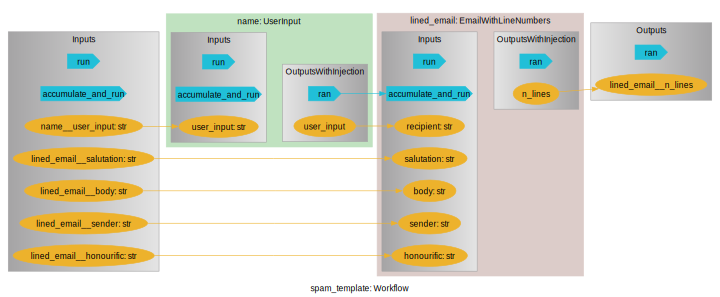

In [15]:
wf2.draw(size=(10,10))

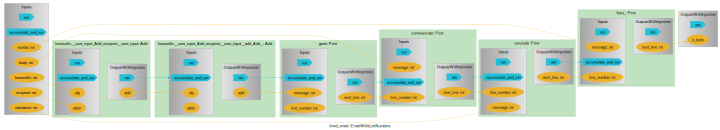

In [16]:
wf2.lined_email.draw(size=(10,10))

## What else?

To learn more, take a look at the `deepdive.ipynb` notebook, and/or start looking through the class docstrings. Here's a brief map of what you're still missing:

- Distributing node execution onto remote processes
  - Parallel computation is available by setting the `.executor` attribute to a compatible executor instance, e.g. `Workflow.create.ProcessPoolExecutor()`
- Acyclic graphs
  - Execution for graphs whose data flow topology is a DAG happens automatically, but you're always free to specify this manually with `Signals`, and indeed _must_ specify the execution flow manually for cyclic graphs -- but cyclic graphs _are_ possible!
- Complex flow nodes
  - If, While, and For nodes are all available for more complex flow control
- Node libraries
  - Check other repos in the pyiron organization for more node packages
  - Most of the current developments focus on running classical atomistics simulations
- Saving and loading finished calculations
  
### Features coming shortly
- Restarting partially executed workflows

### Features planned
- Ontological typing and guided workflow design (see our `ironflow` project for a working prototype)